In [2]:
import pandas as pd # דאטא ובטבלאות
import numpy as np # ספריה חישובית
import matplotlib.pyplot as plt # הצגת גרפים
from pylab import rcParams # שינוי גודל הגרפים
from pylab import * 
from IPython.display import Image # הצגת תמונות

#from matplotlib import pyplot  
import statsmodels.api as sm # חישוב וחלוקה לטרנד, מחזוריות ושאריות

from pmdarima import model_selection, auto_arima # Arima model & Train/Test split for Time series (and not random)
import pmdarima as pm # Arima Library
from prophet import Prophet #Prophet model
from sklearn.ensemble import RandomForestRegressor # Random Forest model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error # מדדי השוואה


In [3]:
#rf long
from pandas import DataFrame
from pandas import concat
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions




# Load the data

In [4]:
df = pd.read_csv("C:/Users/yonad/OneDrive - Bar-Ilan University/Corona Final Project/Data/City_Status_Vaccine_Total.csv")
df.head()

,City_Code,Date,Accumulated_Verified_Cases,Accumulated_Recovered,Accumulated_Deaths,Accumulated_Number_Of_Tests,Accumulated_Vaccination_First_Dose,Accumulated_Vaccination_Second_Dose,Accumulated_Vaccination_Third_Dose,Color_Green,Color_Yellow,Color_Orange,Color_Red,Final_Score
0,26,11/03/2020,0,0,0,0,0,0,0,0,0,0,0,-1.0
1,28,11/03/2020,0,0,0,0,0,0,0,0,0,0,0,-1.0
2,31,11/03/2020,0,0,0,0,0,0,0,0,0,0,0,-1.0
3,41,11/03/2020,0,0,0,0,0,0,0,0,0,0,0,-1.0
4,46,11/03/2020,0,0,0,0,0,0,0,0,0,0,0,-1.0


In [5]:
df = df[["City_Code","Date", "Accumulated_Verified_Cases"]] # רק העמודות שמעניינות

# Check for outliers, null, missing dates and seasonality

In [6]:
df.dtypes

City_Code                      int64
Date                          object
Accumulated_Verified_Cases     int64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y') # המרת התאריך מאובייקט כללי לאובייקט תאריך

In [8]:
df.dtypes

City_Code                              int64
Date                          datetime64[ns]
Accumulated_Verified_Cases             int64
dtype: object

In [9]:
df.isnull().values.any() # בדיקה שאין תאים ריקים 

False

In [10]:
min(df.groupby(["City_Code"]).count()["Accumulated_Verified_Cases"]) # בדיקה שאין מידע חסר

600

In [11]:
max(df.groupby(["City_Code"]).count()["Accumulated_Verified_Cases"]) # בדיקה שאין מידע חסר

600

In [12]:
df.describe()

,City_Code,Accumulated_Verified_Cases
count,156600.000000,156600.000000
mean,2515.823755,1884.276373
std,2580.183491,7200.542768
min,26.000000,0.000000
25%,535.000000,51.000000
50%,1286.000000,316.000000
75%,3725.000000,1317.000000
max,9800.000000,159268.000000


In [ ]:
#בגלל שהערך המקסימלי של מספר המאומתים גדול מאחוזון 75 בצורה משמעותית, החלטנו לבדוק האם יש טעות בדאטה (Outlayer)
##אנו משערים שבגלל שיש פה דאטה של המון ערים, ויש הבדלים משמעותיים בין הערים עצמן - זה יכול לגרום להפרש הגבוה בין הערך המקסימלי לבין אחוזון 75

In [15]:
df[df['Accumulated_Verified_Cases'] == 159268] # חיפשנו את העיר שבה יש את מספר המאומתים הגבוה שגרם לנו לחשוד בחריגה

,City_Code,Date,Accumulated_Verified_Cases
156511,3000,2021-10-31,159268


<AxesSubplot:xlabel='Date'>

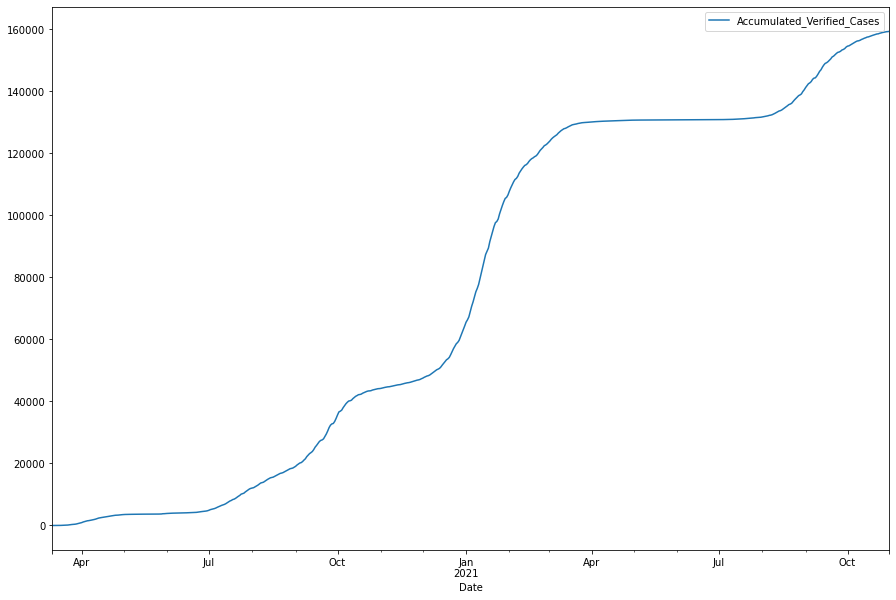

In [16]:
#בחינה של אותה העיר
city3000 = df[df['City_Code'] == 3000]
city3000.plot(x="Date", y="Accumulated_Verified_Cases", figsize=(15,10))

<AxesSubplot:xlabel='Date'>

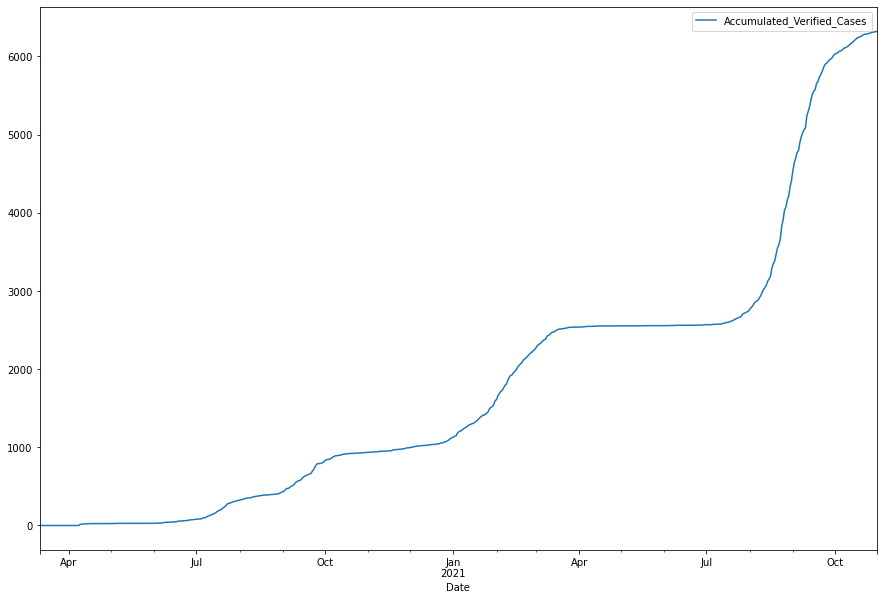

In [17]:
#בחינה של אותה עיר נוספת
city2600 = df[df['City_Code'] == 2600]
city2600.plot(x="Date", y="Accumulated_Verified_Cases", figsize=(15,10))

<AxesSubplot:xlabel='Date'>

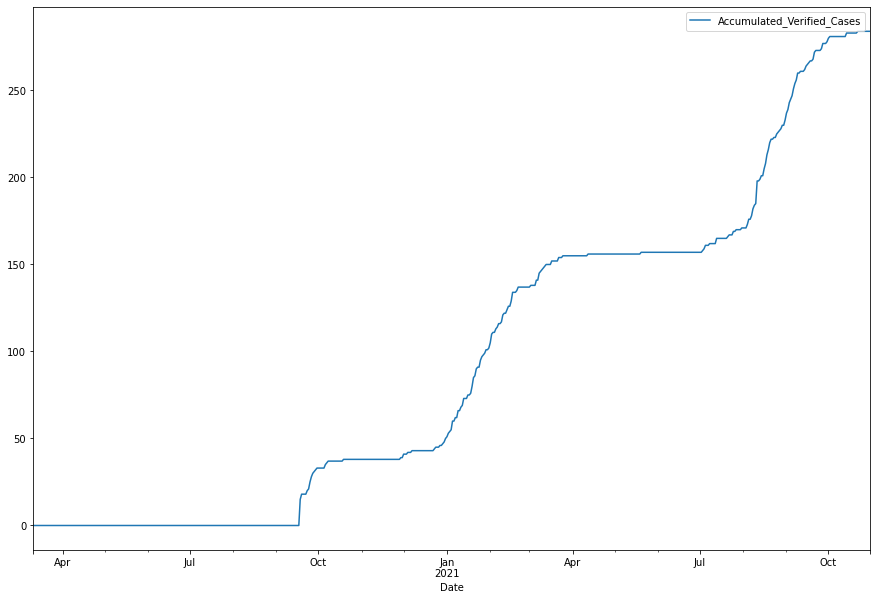

In [18]:
# בחינה של עיר נוספת 
city26 = df.loc[df['City_Code'] == 26]
city26.plot(x="Date", y="Accumulated_Verified_Cases", figsize=(15,10))

In [ ]:
# מכיוון שמדובר בדאטה של זמנים חשוב לחפש מחזוריות בדאטה

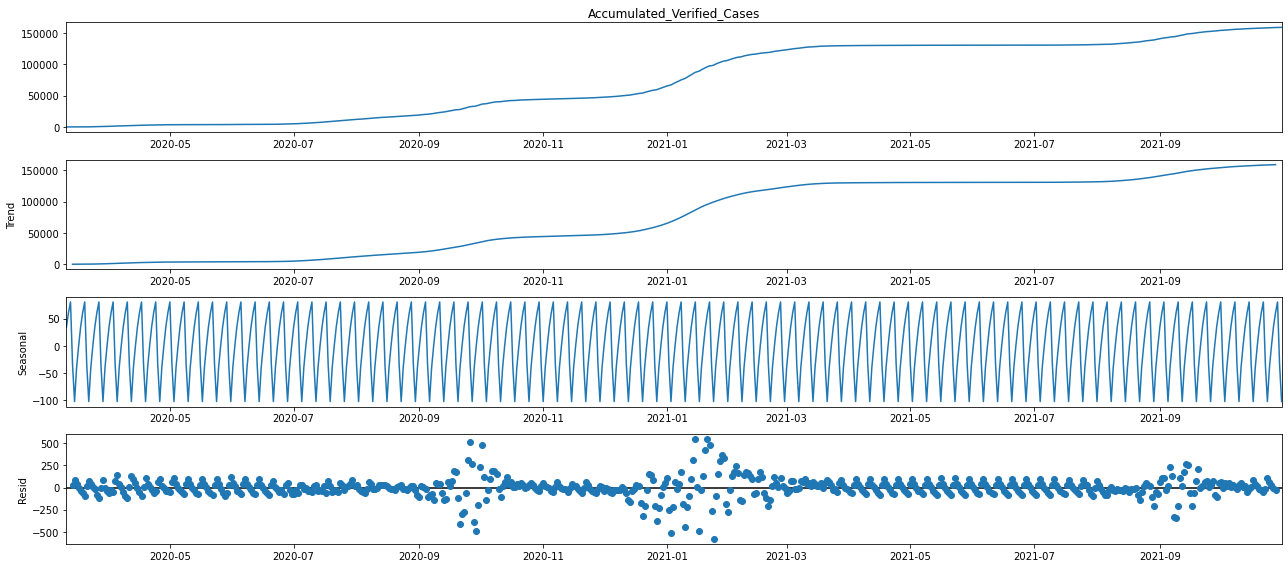

In [19]:
rcParams['figure.figsize'] = 18, 8 # הגדלת גודל הגרף
city3000 = df[df['City_Code'] == 3000] #הגדרת עיר מספר 3000
city3000 = city3000.set_index('Date') # הגדרת התאריך כאינדקס הטבלה 
decomposition = sm.tsa.seasonal_decompose(city3000["Accumulated_Verified_Cases"]) # פירוק הסיגנל למרכיביו
fig = decomposition.plot() # יצירת גרפי הפירוק
plt.show() # הצגתם
# גרף 1 - דאטה מקורי
# גרף 2 - טרנד, כלומר - הכיוון הכללי של הדאטה
# גרף 3 - מחזוריות - עקב הבדלי הערכים בין טווח ההגדרה של הטרנד הכללי לעומת טווח ההגדרה של רכיב המחזוריות, הגענו למסקנה שככה"נ הרכיב המחזורי אינו משמעותי
# גרף 4 - רעש

# Baseline: city 3000, ARIMA vs Prophet

In [20]:
# אימון דוגמא של מודל ארימה על עיר 3000
train, test = model_selection.train_test_split(city3000['Accumulated_Verified_Cases'],train_size = 0.8)
arima = pm.auto_arima(train) # אוטו ארימה מריץ כמה סוגים של מודלי ארימה עם פרמטרים שונים ובוחר את המודל שעבורו הטעות הכי נמוכה
arima_forecast = arima.predict(n_periods=len(test)) #כמה שורות נרצה לחזות קדימה, כלומר את כל אורך הטסט

# אימון דוגמא של מודל פרופט על עיר 3000
df_prophet = df[df['City_Code'] == 3000].copy()
df_prophet.rename(columns={'Date': 'ds', 'Accumulated_Verified_Cases': 'y'}, inplace=True) # מסדרים את העמודות לדרישות המודל
train_p, test_p = model_selection.train_test_split(df_prophet,train_size = 0.8)
m = Prophet() # אתחול משתנה כללי של המודל
m.fit(train_p) # לימוד המודל
future = m.make_future_dataframe(periods=len(test_p)) #הוספת ה120 יום הנותרים, ע"מ להכין את התשתית
forecast_p = m.predict(future)# מחזיר 2 דברים : את הפיט ע"ג הטריין, ומוסיף את הפרדיקט באורך הטסט
# yhat זה מה שהמודל חזה

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


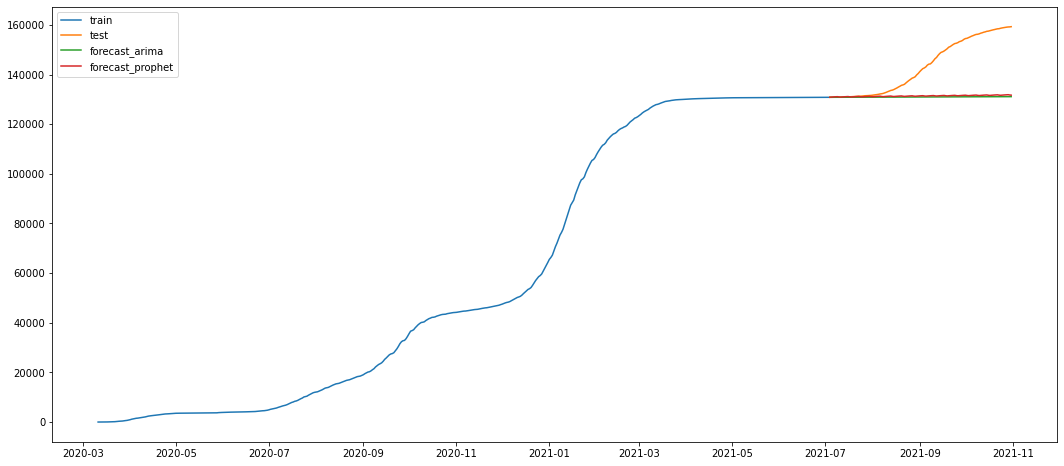

In [21]:
plt.plot(train)
plt.plot(test)
plt.plot(pd.Series(arima_forecast).set_axis(test.index)) # הופך את מערך הפורקסט של ארימה לרשימה ומתיג לפי תאריכים
plt.plot(forecast_p.yhat[-len(test):].set_axis(test.index)) # לוקח את ה-120 יום האחרונים
plt.legend(['train', 'test', 'forecast_arima','forecast_prophet'])
plt.show()

# Baseline: city 26, ARIMA vs Prophet

In [22]:
# אימון דוגמא של מודל ארימה על עיר 26
train, test = model_selection.train_test_split(city26['Accumulated_Verified_Cases'],train_size = 0.8)
arima = pm.auto_arima(train) # אוטו ארימה מריץ כמה סוגים של מודלי ארימה עם פרמטרים שונים ובוחר את המודל שעבורו הטעות הכי נמוכה
arima_forecast = arima.predict(n_periods=len(test)) #כמה שורות נרצה לחזות קדימה, כלומר את כל אורך הטסט

# אימון דוגמא של מודל פרופט על עיר 26
df_prophet = df[df['City_Code'] == 26].copy()
df_prophet.rename(columns={'Date': 'ds', 'Accumulated_Verified_Cases': 'y'}, inplace=True) # מסדרים את העמודות לדרישות המודל
train_p, test_p = model_selection.train_test_split(df_prophet,train_size = 0.5)
m = Prophet() # אתחול משתנה כללי של המודל
m.fit(train_p) # לימוד המודל
future = m.make_future_dataframe(periods=len(test_p)) #הוספת ה120 יום הנותרים, ע"מ להכין את התשתית
forecast_p = m.predict(future)# מחזיר 2 דברים : את הפיט ע"ג הטריין, ומוסיף את הפרדיקט באורך הטסט
# yhat 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


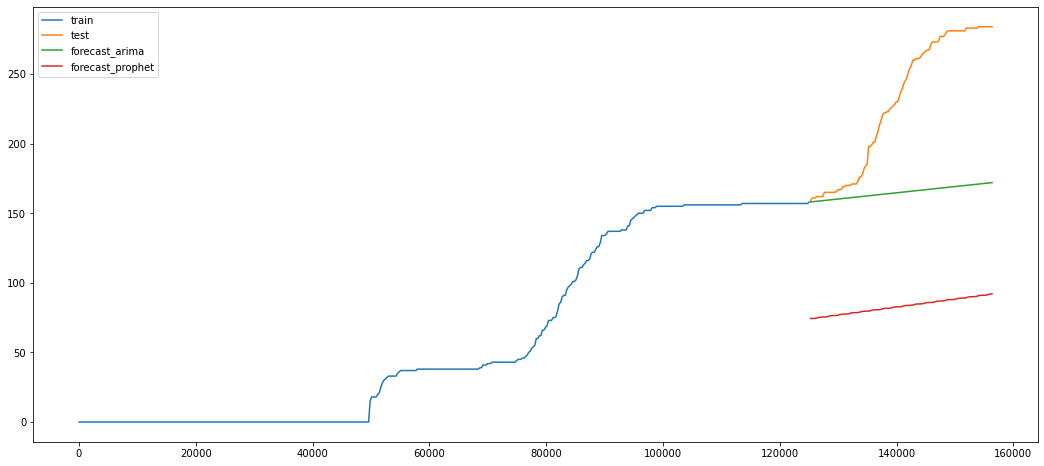

In [23]:
plt.plot(train)
plt.plot(test)
plt.plot(pd.Series(arima_forecast).set_axis(test.index)) # הופך את מערך הפורקסט של ארימה לרשימה ומציג לפי תאריכים
plt.plot(forecast_p.yhat[-len(test):].set_axis(test.index)) # לוקח את ה-120 יום האחרונים
plt.legend(['train', 'test', 'forecast_arima','forecast_prophet'])
plt.show()

# Reduce the train size to half (300)

In [24]:
city = 3000

In [25]:
#Prophet's format convert (rename columns)
df_prophet = df.loc[df['City_Code'] == city].iloc[300:].copy()
df_prophet.rename(columns={'Date': 'ds', 'Accumulated_Verified_Cases': 'y'}, inplace=True)
train_p, test_p = model_selection.train_test_split(df_prophet,train_size = 0.8)
m = Prophet() #Initializing prophet module
m.fit(train_p)
future = m.make_future_dataframe(periods=len(test_p)) #הוספת ה120 יום הנותרים, ע"מ להכין את התשתית
forecast_p = m.predict(future)# מחזיר 2 דברים : את הפיט ע"ג הטריין, ומוסיף את הפרדיקט באורך הטסט
# yhat זה מה שהמודל חזה

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:

temp = df.loc[df['City_Code'] == city].iloc[300:]
temp = temp.set_index('Date')

train, test = model_selection.train_test_split(temp['Accumulated_Verified_Cases'],train_size = 0.8)
arima = pm.auto_arima(train)
forecast = arima.predict(n_periods=len(test)) #כמה שורות נרצה לחזות קדימה, כלומר את כל אורך הטסט
#להבין טוב מה זה Auto Arima 

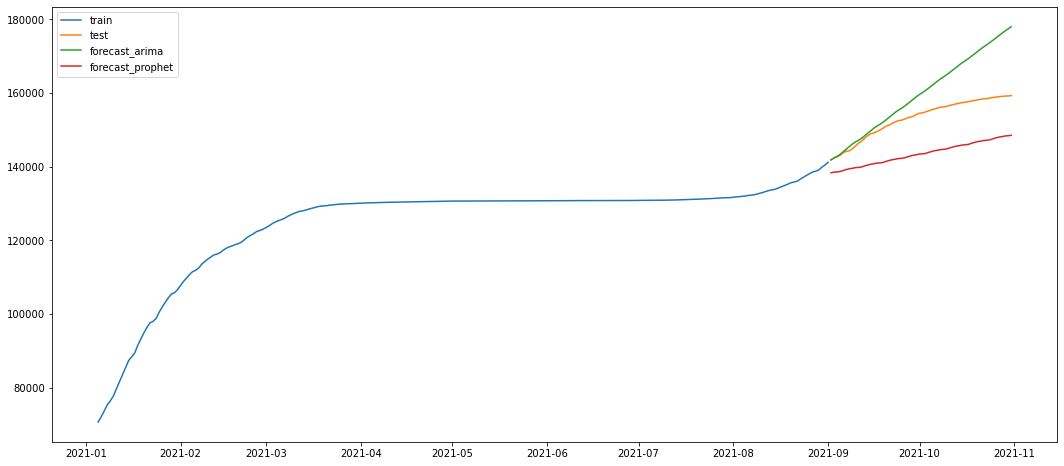

In [27]:
plt.plot(train)
plt.plot(test)
plt.plot(pd.Series(forecast).set_axis(test.index))
plt.plot(forecast_p.yhat[-len(test):].set_axis(test.index))
plt.legend(['train', 'test', 'forecast_arima','forecast_prophet'])
plt.show()


# Random Forest to the help!

## compare some rf configurations (number of samples to learn on, number of estimators)

In [28]:
n_data_to_learn_on = 60
temp = df.loc[df['City_Code'] == city].iloc[300:].copy()
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp,train_size = 0.8)
n_predictions = len(test)
list_data = list(train.Accumulated_Verified_Cases)
predictions = list()

for i in range(n_predictions):
    train = series_to_supervised(list_data, n_in=n_data_to_learn_on)

    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new prediction
    row = list_data[-n_data_to_learn_on:]
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    predictions.append(yhat)
    list_data.append(yhat[0])
    
n_data_to_learn_on = 30
temp = df.loc[df['City_Code'] == city].iloc[300:].copy()
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp,train_size = 0.8)
n_predictions = len(test)
list_data = list(train.Accumulated_Verified_Cases)
predictions_30 = list()

for i in range(n_predictions):
    train = series_to_supervised(list_data, n_in=n_data_to_learn_on)

    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new prediction
    row = list_data[-n_data_to_learn_on:]
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    predictions_30.append(yhat)
    list_data.append(yhat[0])
    
n_data_to_learn_on = 6
temp = df.loc[df['City_Code'] == city].iloc[300:].copy()
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp,train_size = 0.8)
n_predictions = len(test)
list_data = list(train.Accumulated_Verified_Cases)
predictions_6 = list()

for i in range(n_predictions):
    train = series_to_supervised(list_data, n_in=n_data_to_learn_on)

    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new prediction
    row = list_data[-n_data_to_learn_on:]
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    predictions_6.append(yhat)
    list_data.append(yhat[0])
    


## Reduce number of estimators from 1000 to 500

In [31]:
n_data_to_learn_on = 6
temp = df.loc[df['City_Code'] == city].iloc[300:].copy()
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp,train_size = 0.8)
n_predictions = len(test)
list_data = list(train.Accumulated_Verified_Cases)
predictions_6_500 = list()

for i in range(n_predictions):
    train = series_to_supervised(list_data, n_in=n_data_to_learn_on)

    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=500)
    model.fit(trainX, trainy)
    # construct an input for a new prediction
    row = list_data[-n_data_to_learn_on:]
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    predictions_6_500.append(yhat)
    list_data.append(yhat[0])

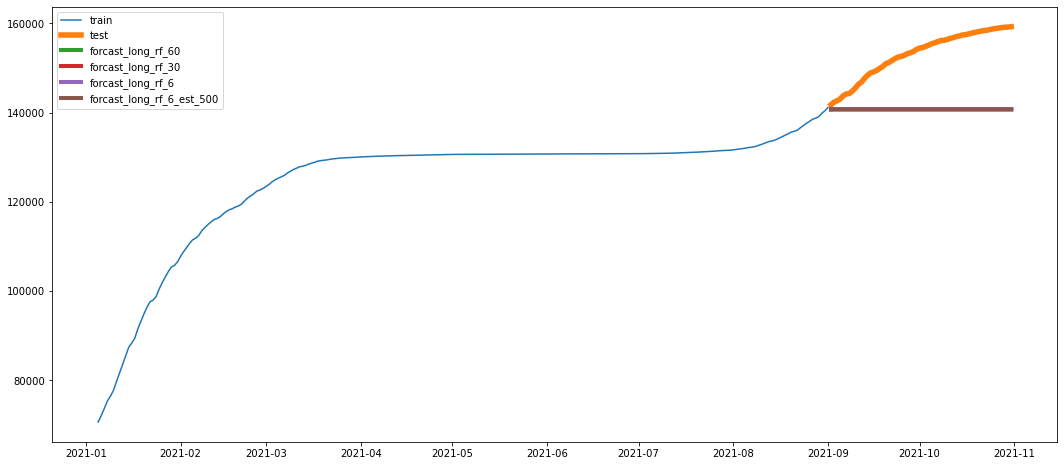

In [32]:
temp = df.loc[df['City_Code'] == city].iloc[300:]
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp['Accumulated_Verified_Cases'],train_size = 0.8)

plt.plot(train)
plt.plot(test,linewidth=5.5)
plt.plot(pd.Series(predictions).set_axis(test.index),linewidth=4, linestyle='-')#60
plt.plot(pd.Series(predictions_30).set_axis(test.index),linewidth=4, linestyle='-')
plt.plot(pd.Series(predictions_6).set_axis(test.index),linewidth=4, linestyle='-')
plt.plot(pd.Series(predictions_6_500).set_axis(test.index),linewidth=4, linestyle='-')


plt.legend(['train', 'test', 'forcast_long_rf_60','forcast_long_rf_30', 'forcast_long_rf_6', 'forcast_long_rf_6_est_500'])
plt.show()

In [ ]:
#all look the same..

# Compare all 3 models on 300 data points.

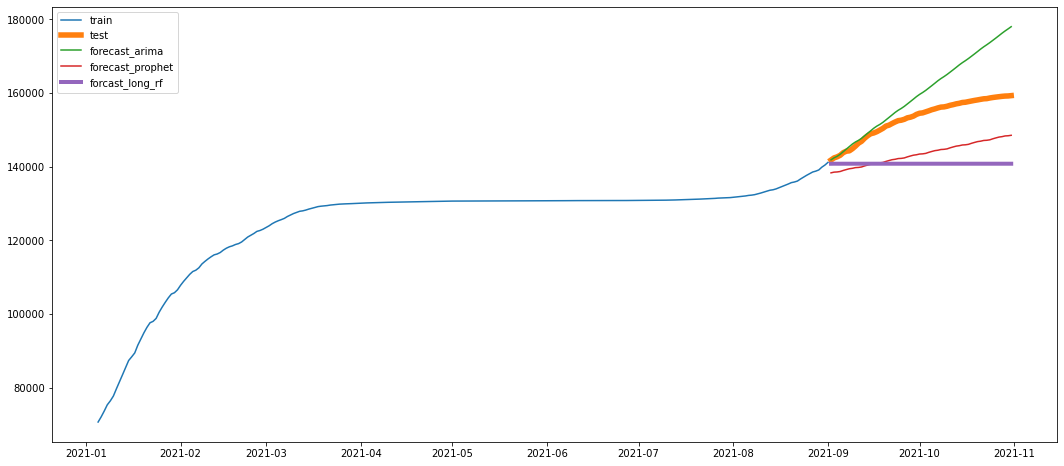

In [35]:
temp = df.loc[df['City_Code'] == city].iloc[300:]
temp = temp.set_index('Date')
train, test = model_selection.train_test_split(temp['Accumulated_Verified_Cases'],train_size = 0.8)

plt.plot(train)
plt.plot(test,linewidth=5.5)
plt.plot(pd.Series(forecast).set_axis(test.index))
plt.plot(forecast_p.yhat[-len(test):].set_axis(test.index))
plt.plot(pd.Series(predictions).set_axis(test.index),linewidth=4, linestyle='-')#60


plt.legend(['train', 'test', 'forecast_arima','forecast_prophet','forcast_long_rf'])
plt.show()


# Calculate error metrics for all models across all cities 

In [55]:
arima_rmse = np.sqrt(mean_squared_error(test, forecast))#הפרש בין הערכים והעלאה בריבוע למקרה של ערכים שליליים, לכל זה ממוצע ואז שורש כדי לבטל את הריבוע
arima_mae = mean_absolute_error(test, forecast)
arima_r2 = r2_score(test, forecast)
print('arima:')
print(f'rmse:{arima_rmse} , mae:{arima_mae} , r2:{arima_r2} ')
#

rf_rmse = np.sqrt(mean_squared_error(test, pd.Series(predictions)))#הפרש בין הערכים והעלאה בריבוע למקרה של ערכים שליליים, לכל זה ממוצע ואז שורש כדי לבטל את הריבוע
rf_mae = mean_absolute_error(test, pd.Series(predictions))
rf_r2 = r2_score(test, pd.Series(predictions))
rf_mape = mean_absolute_percentage_error(test, pd.Series(predictions))
print('rf_long:')
print(f'rmse:{rf_rmse} , mae:{rf_mae} , r2:{rf_r2} ')

prophet_rmse = np.sqrt(mean_squared_error(test, forecast_p.yhat[-len(test):])) #השוואה בין מה שהיה בפועל בטסט שהוא לא ראה לעומת הפרדיקציה (כלומר ה120 יום מהסוף)
prophet_mae = mean_absolute_error(test, forecast_p.yhat[-len(test):])
prophet_r2 = r2_score(test, forecast_p.yhat[-len(test):])
prophet_mape = mean_absolute_percentage_error(test, forecast_p.yhat[-len(test):])
print('prophet')
print(f'rmse:{prophet_mae} , mae:{prophet_mae} , r2:{prophet_r2} ')

arima:
rmse:8895.19287444833 , mae:6771.825780331311 , r2:-1.884529794146836 
rf_long:
rmse:13360.742686591582 , mae:12291.524208315901 , r2:-5.507669528299279 
prophet
rmse:9625.700629594461 , mae:9625.700629594461 , r2:-2.5924214545039037 


In [61]:
path = 'C:/Users/yonad/OneDrive - Bar-Ilan University/Corona Final Project/ARCHIVE/Archive_python/'
arima_mae_all = pd.read_csv(path + 'arima_mae_all.csv',names=['header'])
arima_mape_all = pd.read_csv(path + 'arima_mape_all.csv',names=['header'])
arima_r2_all = pd.read_csv(path + 'arima_r2_all.csv',names=['header'])
arima_rmse_all = pd.read_csv(path + 'arima_rmse_all.csv',names=['header'])

prophet_mae_all = pd.read_csv(path + 'prophet_mae_all.csv',names=['header'])
prophet_mape_all = pd.read_csv(path + 'prophet_mape_all.csv',names=['header'])
prophet_r2_all = pd.read_csv(path + 'prophet_r2_all.csv',names=['header'])
prophet_rmse_all = pd.read_csv(path + 'prophet_rmse_all.csv',names=['header'])

rf_long_mae_all = pd.read_csv(path + 'rf_long_mae_all.csv',names=['header'])
rf_long_mape_all = pd.read_csv(path + 'rf_long_mape_all.csv',names=['header'])
rf_long_r2_all = pd.read_csv(path + 'rf_long_r2_all.csv',names=['header'])
rf_long_rmse_all = pd.read_csv(path + 'rf_long_rmse_all.csv',names=['header'])


# Comapre r2

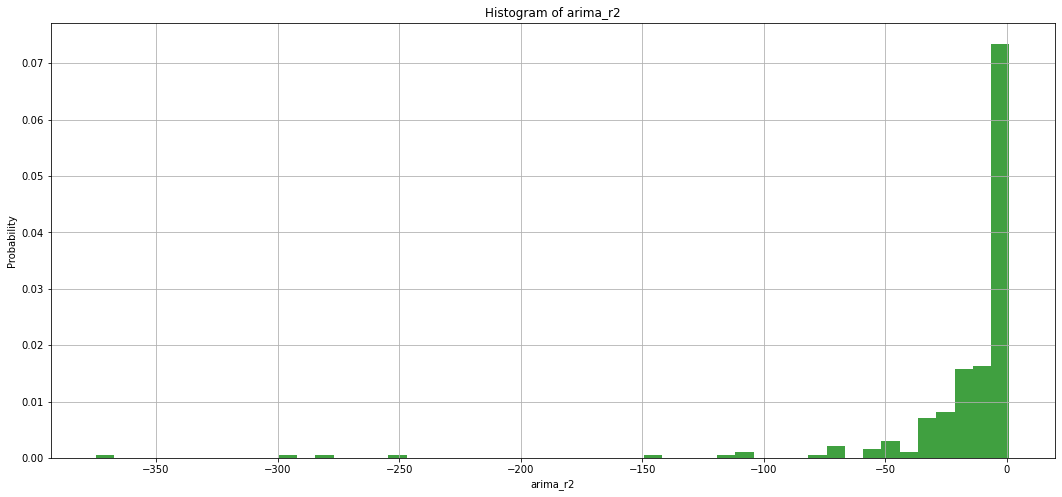

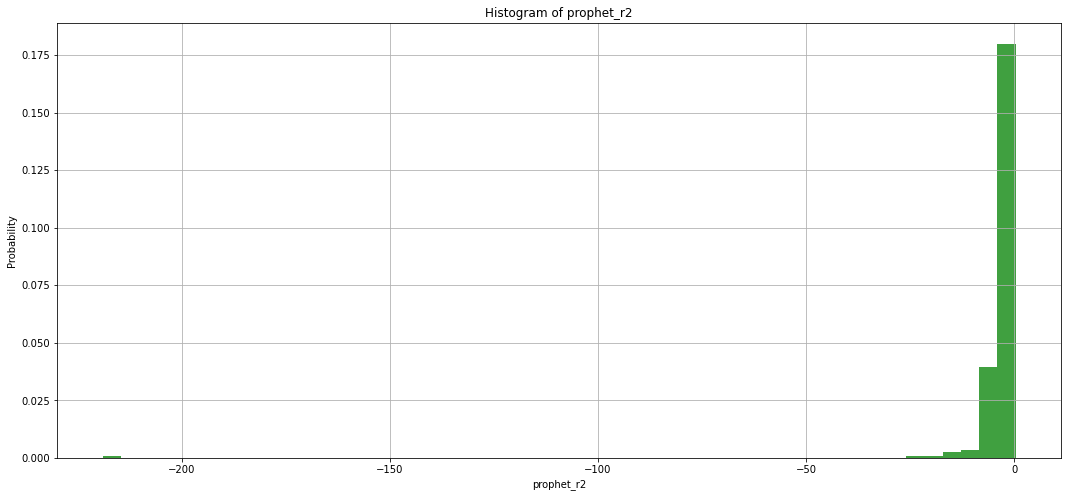

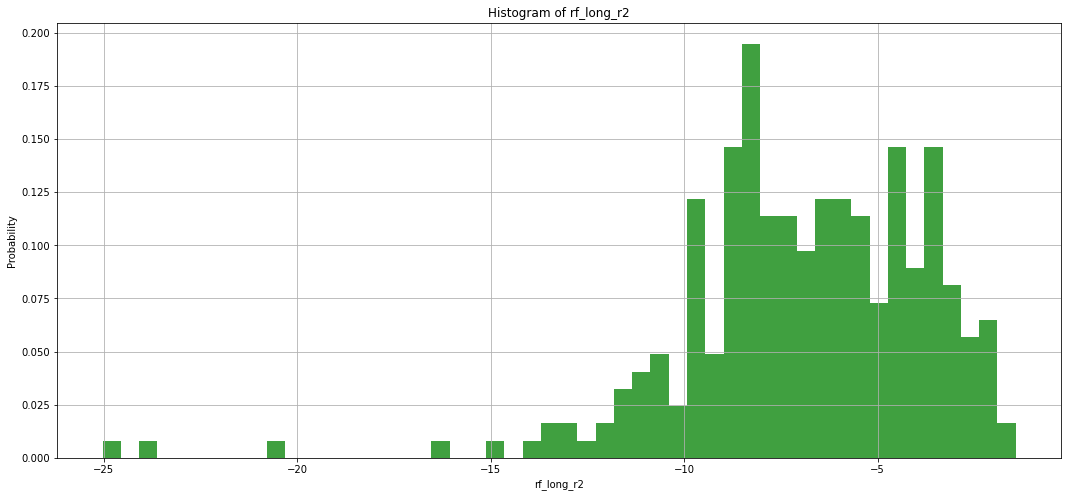

In [63]:
# the histogram of the data
n, bins, patches = plt.hist(arima_r2_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('arima_r2')
plt.ylabel('Probability')
plt.title('Histogram of arima_r2')
plt.grid(True)
plt.show()

# the histogram of the data
n, bins, patches = plt.hist(prophet_r2_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('prophet_r2')
plt.ylabel('Probability')
plt.title('Histogram of prophet_r2')
plt.grid(True)
plt.show()


# the histogram of the data
n, bins, patches = plt.hist(rf_long_r2_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('rf_long_r2')
plt.ylabel('Probability')
plt.title('Histogram of rf_long_r2')
plt.grid(True)
plt.show()

# Compare RMSE

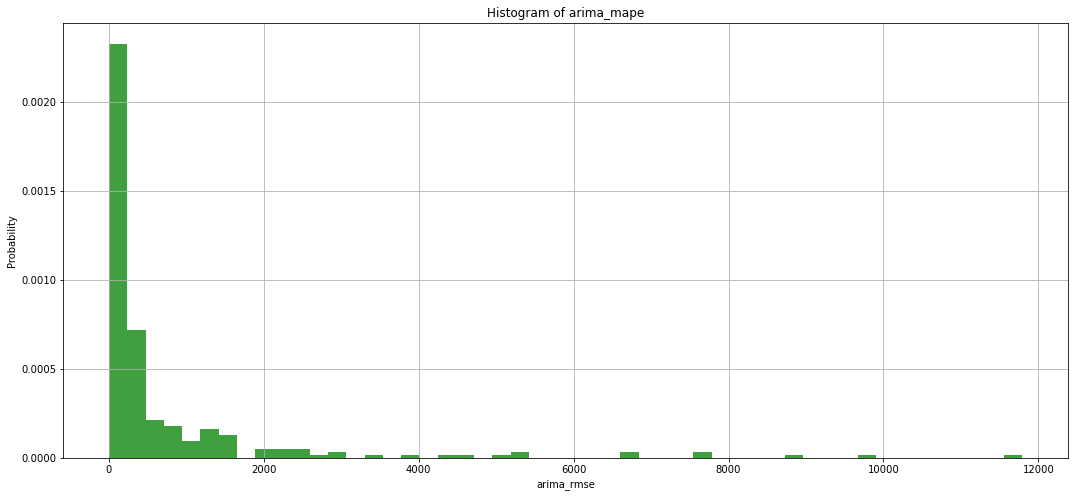

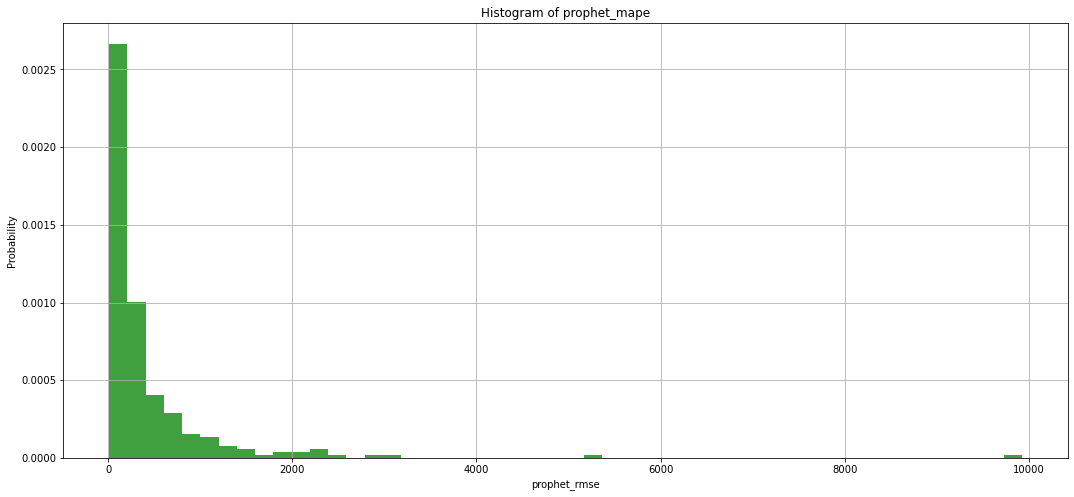

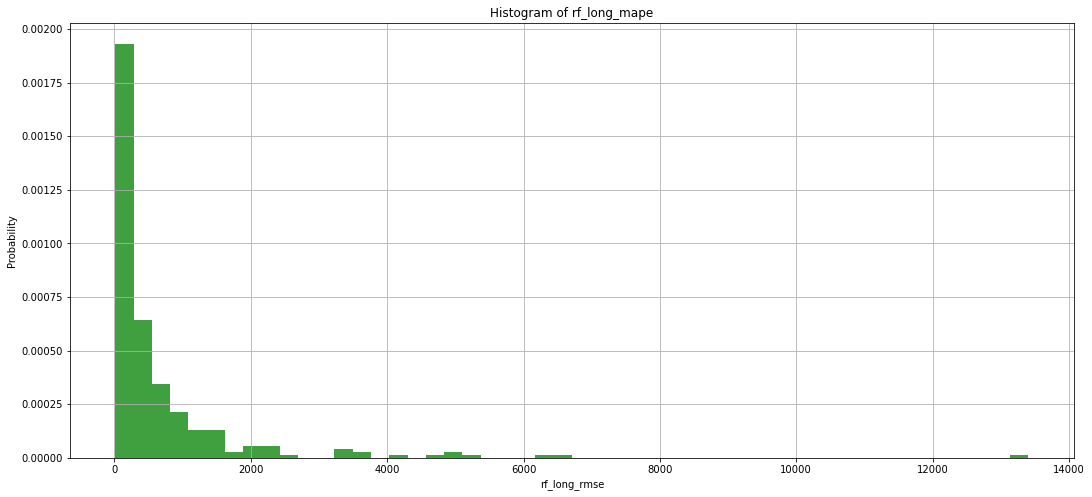

In [64]:
# the histogram of the data
n, bins, patches = plt.hist(arima_rmse_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('arima_rmse')
plt.ylabel('Probability')
plt.title('Histogram of arima_mape')
plt.grid(True)
plt.show()

# the histogram of the data
n, bins, patches = plt.hist(prophet_rmse_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('prophet_rmse')
plt.ylabel('Probability')
plt.title('Histogram of prophet_mape')
plt.grid(True)
plt.show()


# the histogram of the data
n, bins, patches = plt.hist(rf_long_rmse_all, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('rf_long_rmse')
plt.ylabel('Probability')
plt.title('Histogram of rf_long_mape')
plt.grid(True)
plt.show()